In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
from tqdm import tqdm

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
# import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict

In [2]:
from monk import nb, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.init_project(name="2d-osc-shear", root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12, 0.04, 0.06, 0.07], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [27]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp.prep

    expers = sorted(glob.glob(job.fn("longer_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in expers:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        d2min_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/d2min-and-strain_rev-and-dev_period-{period}.npz"
        soft_strob = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        final_soft = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        virial_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-virial-xy_period-{period}.parquet"
        zoftness_path = f"longer_experiments/max-shear-{max_shear}/temp-{temp}/zoftness_period-{period}.parquet"
        
        if float(period) != 1000.0 or float(temp) >= 2e-2 or float(temp) < 1e-2 or float(max_shear) != 0.04:
            continue

        # print(sp)

        d2min = np.load(job.fn(d2min_path), allow_pickle=True)
        df_soft = pd.read_parquet(job.fn(soft_strob))[-2:-1]
        df_zoft = pd.read_parquet(job.fn(zoftness_path))
        df_zoft2 = (df_zoft.groupby('frame')
            .agg({'zoftness': lambda x: np.vstack(x.to_numpy())[:,0], 'output': lambda x: np.vstack(x.to_numpy()).reshape(-1)})
            .reset_index()
        )

        df_final_soft = pd.read_parquet(job.fn(final_soft))
        
        virial_xys = pd.read_parquet(job.fn(virial_path))
        df_soft = df_soft.rename({"id": "typeid"})
        # join dfs
        # df = df_d2min.join(df_soft, on="frame")
        df = df_soft.merge(df_zoft2, on="frame")
        # break
        output[sp].append({"soft": df, "final_soft": df_final_soft, "d2min": d2min, "virial_xy": virial_xys})
        # break
    # break

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='ESL')


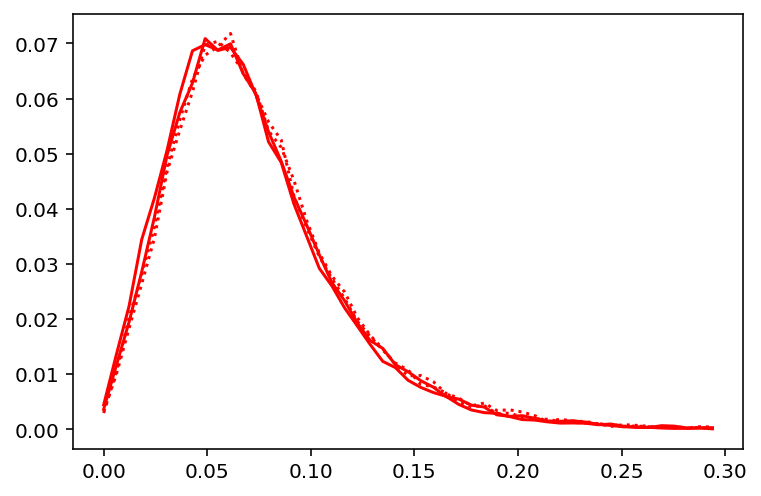

In [10]:
bins2 = np.linspace(0, 0.3, 50)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.05)

for sp, data in output.items():

    if sp.prep == "ESL":
        ls = "-"
    else:
        ls = ":"
    print(sp)
    # d = data[0]
    out = []
    zofts = []
    zofts2 = []
    zofts3 = []
    for d in data:
    
        i = 0
        frame = d["d2min"]["frame"][i*40]
        # print(frame)

        soft = d["soft"][d["soft"]["frame"] == frame]["soft"]
        soft = np.vstack(soft.to_numpy()).reshape(-1)
        soft2 = d["soft"][d["soft"]["frame"] == frame]["zoftness"]
        soft2 = np.vstack(soft2.to_numpy()).reshape(-1)
        soft3 = d["soft"][d["soft"]["frame"] == frame]["output"]
        soft3 = np.vstack(soft3.to_numpy()).reshape(-1)
        virial_xy = d["virial_xy"]["virial_mags"]

        init_virial_xy = virial_xy[i]

        rearrange = np.argmax(d["d2min"]["d2min"] > 0.08, axis=0)
        rearrange = np.ma.masked_equal(rearrange, 0)
        idx = np.where((rearrange.mask == False))[0]


        max_xy_strain = d["d2min"]["dev_strain_mag"][:, idx].T
        rearrange = rearrange[idx].data
        soft = soft[idx]
        soft2 = soft2[idx]
        soft3 = soft3[idx]
        m2 = []
        m3 = []
        m4 = []
        virs = []
        for k, r in enumerate(rearrange):
            # print(r)
            # m2.append(max_xy_strain[k, r])
            m2.append(soft[k])
            m3.append(soft2[k])
            m4.append(soft3[k])
            # virs.append(np.abs(virial_xy[i*40 + r][k]))
            virs.append(max_xy_strain[k, r])
    
        out.append(virs)
        zofts.append(m2)
        zofts2.append(m3)
        zofts3.append(m4)
    y = np.concatenate(out)
    for z, cs in zip([zofts, zofts2, zofts3], ["r", "b", "g"]):
        x = np.concatenate(z)
        x = (x - np.mean(x))/np.std(x)

        tmp_df = pd.DataFrame({"x": x, "y": y})
        lq = np.quantile(tmp_df["x"], 0.05)
        hq = np.quantile(tmp_df["x"], 0.95)
        bins = np.linspace(lq, hq, 3)
        cuts = pd.cut(tmp_df["x"], bins)
        tmp_df["cuts"] = cuts
        for cut, tdf in tmp_df.groupby("cuts"):
            H, _ = np.histogram(tdf["y"], bins=bins2)
            plt.plot(bins2[:-1], H/np.sum(H), ls = ls, color=cs, label=f"{sp.prep} {sp.max_shear}")
        # tmp_df2 = tmp_df.groupby("cuts").agg({"y": lambda x: np.mean(x)})
        # x = [x.mid for x in tmp_df2.index]
        # plt.plot(x, tmp_df2["y"], ls = ls, color=cs, label=f"{sp.prep} {sp.max_shear}")
        break
    # H, _ = np.histogram(max_xy_strain, bins=bins, density=False)
    # plt.plot(bins[:-1], H/np.sum(H), ls = ls, color=cmap(norm(sp.max_shear)), label=f"{sp.prep} {sp.max_shear}")
    #     break
    # break

# plt.xscale('log')
# plt.xlabel(r"$|\sigma_{xy}|$ just prior to rearrangement")
# plt.ylabel('counts')
plt.xlabel("")

# plt.text(0.1, 0.8, f"S > 0.0", transform=plt.gca().transAxes, size="xx-large")

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r"prep, $\gamma_{max}$")

plt.savefig("zoftness-yield-stress.png", dpi=300, bbox_inches="tight")

In [12]:
len()

13024

In [240]:
d["virial_xy"]["virial_mags"][-30:-10]

171    [2.8234273167514403, 2.2087675039909316, 4.941...
172    [2.7980789212379737, 2.1676665341936334, 4.962...
173    [2.5935522010297074, 1.9737868180649505, 4.774...
174    [2.6256472139174956, 2.071736617447193, 4.6698...
175    [2.26609226906908, 2.1945748955436186, 4.58033...
176    [1.994919234063956, 2.345086065544183, 4.23746...
177    [1.5761732794122685, 2.229728449724107, 4.1397...
178    [1.0463322595024798, 2.3583429341113034, 3.154...
179    [1.3981375973810686, 2.7048851333034993, 2.607...
180    [2.194949997914471, 2.5909830034176062, 2.2955...
181    [3.1042534146776104, 2.860798819091803, 1.7694...
182    [3.0686905469659598, 2.9638720720328355, 1.612...
183    [3.0308385938986055, 3.058468012733001, 3.4302...
184    [3.0778428031150966, 3.198805061512099, 3.5077...
185    [3.122029040995396, 0.8687229308259267, 3.4782...
186    [3.080612179021597, 0.9752401278182584, 3.2953...
187    [3.1402380893390593, 1.0882930824117787, 3.304...
188    [3.125539215210301, 0.94

Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='ESL')


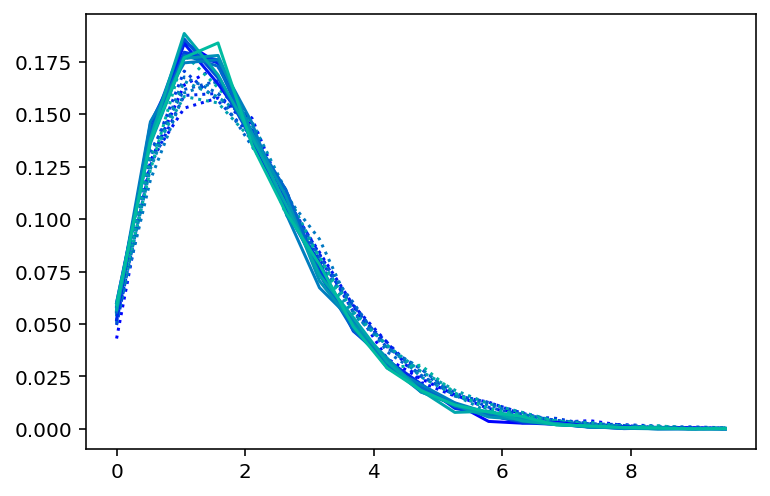

In [61]:
bins2 = np.linspace(0, 10, 20)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.05)

for sp, data in output.items():

    if sp.prep == "ESL":
        ls = "-"
    else:
        ls = ":"
    print(sp)
    # d = data[0]
    out = []
    zofts = []
    zofts2 = []
    zofts3 = []
    for d in data:
    
        i = 0
        frame = d["d2min"]["frame"][i*40]
        # print(frame)

        soft = d["soft"][d["soft"]["frame"] == frame]["soft"]
        soft = np.vstack(soft.to_numpy()).reshape(-1)
        soft2 = d["soft"][d["soft"]["frame"] == frame]["zoftness"]
        soft2 = np.vstack(soft2.to_numpy()).reshape(-1)
        soft3 = d["soft"][d["soft"]["frame"] == frame]["output"]
        soft3 = np.vstack(soft3.to_numpy()).reshape(-1)
        virial_xy = d["virial_xy"]["virial_mags"][-30:-10].to_numpy()

        final_soft_df = d["final_soft"]
        final_soft = np.vstack(df_final_soft.iloc[-30:-10]["soft"].to_numpy())
        # init_virial_xy = virial_xy[i]

        rearrange = np.argmax(d["d2min"]["d2min"] > 0.08, axis=0)
        rearrange = np.ma.masked_equal(rearrange, 0)
        idx = np.where((rearrange.mask == False))[0]


        max_xy_strain = d["d2min"]["dev_strain_mag"][:, idx].T
        rearrange = rearrange[idx].data
        soft = soft[idx]
        soft2 = soft2[idx]
        soft3 = soft3[idx]
        m2 = []
        m3 = []
        m4 = []
        virs = []
        for k, r in enumerate(rearrange):
            # print(r)
            # m2.append(max_xy_strain[k, r])
            # m2.append(soft[k])
            m2.append(final_soft[r, k])
            m3.append(soft2[k])
            m4.append(soft3[k])
            virs.append(np.abs(virial_xy[r][k]))
            # virs.append(max_xy_strain[k, r])
    
        out.append(virs)
        zofts.append(m2)
        zofts2.append(m3)
        zofts3.append(m4)
    y = np.concatenate(out)
    cmap = cm.winter
    norm = colors.Normalize(vmin=-1, vmax=2)
    for z, cs in zip([zofts2, zofts2, zofts3], ["r", "b", "g"]):
        x = np.concatenate(z)
        x = (x - np.mean(x))/np.std(x)

        tmp_df = pd.DataFrame({"x": x, "y": y})
        lq = np.quantile(tmp_df["x"], 0.1)
        hq = np.quantile(tmp_df["x"], 0.9)
        bins = np.linspace(lq, hq, 11)
        cuts = pd.cut(tmp_df["x"], bins)
        tmp_df["cuts"] = cuts
        for cut, tdf in tmp_df.groupby("cuts"):
            H, _ = np.histogram(tdf["y"], bins=bins2)
            plt.plot(bins2[:-1], H/np.sum(H), ls = ls, color=cmap(norm(cut.mid)), label=f"{sp.prep} {sp.max_shear}")
        # tmp_df2 = tmp_df.groupby("cuts").agg({"y": lambda x: np.mean(x)})
        # x = [x.mid for x in tmp_df2.index]
        # plt.plot(x, tmp_df2["y"], ls = ls, color=cs, label=f"{sp.prep} {sp.max_shear}")
        break
    # H, _ = np.histogram(max_xy_strain, bins=bins, density=False)
    # plt.plot(bins[:-1], H/np.sum(H), ls = ls, color=cmap(norm(sp.max_shear)), label=f"{sp.prep} {sp.max_shear}")
    #     break
    # break

# plt.xscale('log')
# plt.xlabel(r"$|\sigma_{xy}|$ just prior to rearrangement")
# plt.ylabel('counts')
plt.xlabel("")

# plt.text(0.1, 0.8, f"S > 0.0", transform=plt.gca().transAxes, size="xx-large")

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r"prep, $\gamma_{max}$")

plt.savefig("zoftness-yield-stress.png", dpi=300, bbox_inches="tight")

Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='HTL')
Statepoint(max_shear=0.04, period=1000.0, temp=0.019836, prep='ESL')


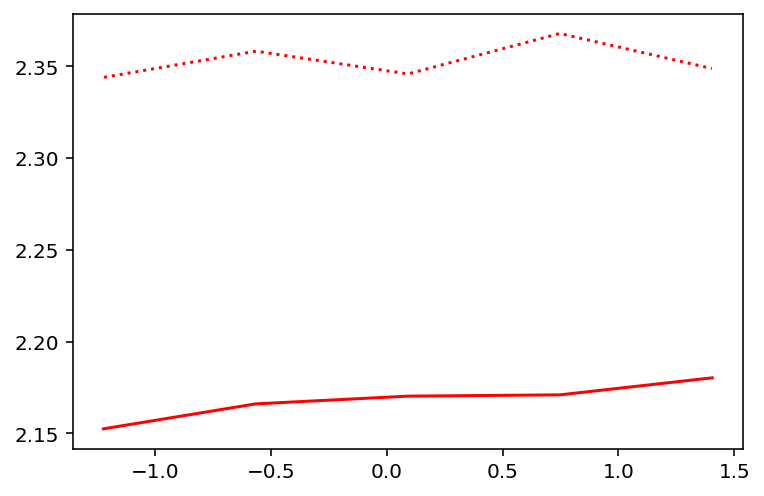

In [60]:
bins2 = np.linspace(0, 10, 50)

cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.05)

for sp, data in output.items():

    if sp.prep == "ESL":
        ls = "-"
    else:
        ls = ":"
    print(sp)
    # d = data[0]
    out = []
    zofts = []
    zofts2 = []
    zofts3 = []
    for d in data:
    
        i = 0
        frame = d["d2min"]["frame"][i*40]
        # print(frame)

        soft = d["soft"][d["soft"]["frame"] == frame]["soft"]
        soft = np.vstack(soft.to_numpy()).reshape(-1)
        soft2 = d["soft"][d["soft"]["frame"] == frame]["zoftness"]
        soft2 = np.vstack(soft2.to_numpy()).reshape(-1)
        soft3 = d["soft"][d["soft"]["frame"] == frame]["output"]
        soft3 = np.vstack(soft3.to_numpy()).reshape(-1)
        virial_xy = d["virial_xy"]["virial_mags"][-30:-10].to_numpy()


        final_soft_df = d["final_soft"]
        final_soft = np.vstack(df_final_soft.iloc[-30:-10]["soft"].to_numpy())
        # init_virial_xy = virial_xy[i]

        rearrange = np.argmax(d["d2min"]["d2min"] > 0.08, axis=0) - 1
        rearrange = np.ma.masked_equal(rearrange, -1)
        idx = np.where((rearrange.mask == False))[0]


        max_xy_strain = d["d2min"]["dev_strain_mag"][:, idx].T
        rearrange = rearrange[idx].data
        final_soft = final_soft[:, idx]
        soft = soft[idx]
        soft2 = soft2[idx]
        soft3 = soft3[idx]
        m2 = []
        m3 = []
        m4 = []
        virs = []
        for k, r in enumerate(rearrange):
            # print(r)
            # m2.append(max_xy_strain[k, r])
            # m2.append(soft[k])
            m2.append(final_soft[r, k])
            m3.append(soft2[k])
            m4.append(soft3[k])
            virs.append(np.abs(virial_xy[r][k]))
            # virs.append(max_xy_strain[k, r])
    
        out.append(virs)
        zofts.append(m2)
        zofts2.append(m3)
        zofts3.append(m4)
    y = np.concatenate(out)
    cmap = cm.winter
    norm = colors.Normalize(vmin=-1, vmax=2)
    for z, cs in zip([zofts, zofts2, zofts3], ["r", "b", "g"]):
        x = np.concatenate(z)
        x = (x - np.mean(x))/np.std(x)

        tmp_df = pd.DataFrame({"x": x, "y": y})
        lq = np.quantile(tmp_df["x"], 0.05)
        hq = np.quantile(tmp_df["x"], 0.95)
        bins = np.linspace(lq, hq, 6)
        cuts = pd.cut(tmp_df["x"], bins)
        tmp_df["cuts"] = cuts
        # for cut, tdf in tmp_df.groupby("cuts"):
        #     H, _ = np.histogram(tdf["y"], bins=bins2)
        #     plt.plot(bins2[:-1], H/np.sum(H), ls = ls, color=cmap(norm(cut.mid)), label=f"{sp.prep} {sp.max_shear}")
        tmp_df2 = tmp_df.groupby("cuts").agg({"y": lambda x: np.mean(x)})
        x = [x.mid for x in tmp_df2.index]
        plt.plot(x, tmp_df2["y"], ls = ls, color=cs, label=f"{sp.prep} {sp.max_shear}")
        break
    # H, _ = np.histogram(max_xy_strain, bins=bins, density=False)
    # plt.plot(bins[:-1], H/np.sum(H), ls = ls, color=cmap(norm(sp.max_shear)), label=f"{sp.prep} {sp.max_shear}")
    #     break
    # break

# plt.xscale('log')
# plt.xlabel(r"$|\sigma_{xy}|$ just prior to rearrangement")
# plt.ylabel('counts')
plt.xlabel("")

# plt.text(0.1, 0.8, f"S > 0.0", transform=plt.gca().transAxes, size="xx-large")

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r"prep, $\gamma_{max}$")

plt.savefig("zoftness-yield-stress.png", dpi=300, bbox_inches="tight")

In [35]:
idx[:10]

array([ 0,  1,  2,  3,  8, 10, 12, 13, 16, 18])

In [34]:
rearrange

array([11, 15, 10, ..., 14, 18,  9])

In [17]:
test = np.vstack(virial_xy)

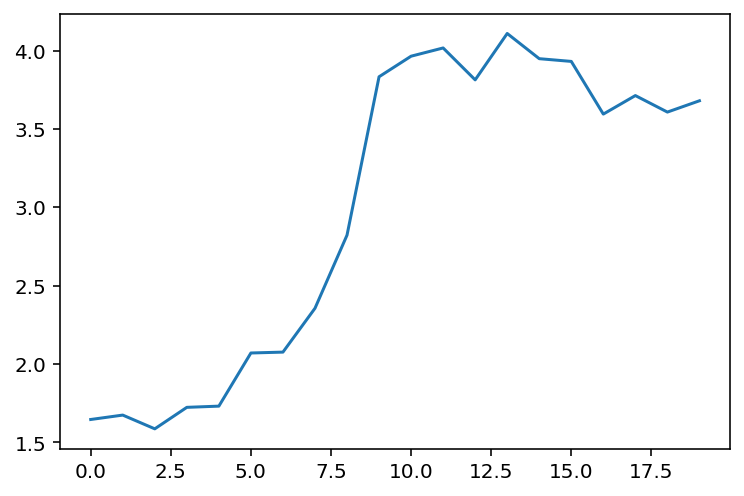

In [18]:
plt.plot(test[:,16])

In [36]:
tmpa = np.abs(d["d2min"]["xx_yy_strain"])
tmpb = np.abs(d["d2min"]["xy_strain"])
tmpc = np.abs(d["d2min"]["dev_strain_mag"])

In [ ]:
np.vstack(df_final_soft["soft"].to_numpy())

In [42]:
final_soft_df = d["final_soft"]

In [44]:
final_soft_df.iloc[-30:-10].head()

,frame,id,soft
171,7970,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.35763368, 0.66169363, 0.46405545, -0.00171..."
172,7971,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.35817224, 0.61684483, 0.46310776, 0.004114..."
173,7972,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.367599, 0.62268573, 0.47965646, 0.01537860..."
174,7973,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.34734884, 0.60072917, 0.5235537, 0.0262869..."
175,7974,"[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, ...","[-0.3844184, 0.5929338, 0.5529858, 0.007019589..."


In [46]:
d["virial_xy"].iloc[-30:-10].head()

,frame,virial_xy,virial_mags
171,7970,"[-1.5725990533828735, -0.5709719061851501, -1....","[2.8234273167514403, 2.2087675039909316, 4.941..."
172,7971,"[-1.5543427467346191, -0.47090983390808105, -1...","[2.7980789212379737, 2.1676665341936334, 4.962..."
173,7972,"[-1.4844505786895752, -0.40374594926834106, -1...","[2.5935522010297074, 1.9737868180649505, 4.774..."
174,7973,"[-1.5030162334442139, -0.36564382910728455, -1...","[2.6256472139174956, 2.071736617447193, 4.6698..."
175,7974,"[-1.3685632944107056, -0.2921961843967438, -1....","[2.26609226906908, 2.1945748955436186, 4.58033..."


In [47]:
final_soft = np.vstack(df_final_soft.iloc[-30:-10]["soft"].to_numpy())

In [38]:
tmp2 = d["d2min"]["d2min"]

In [26]:
soft

array([-0.5309705 ,  0.6674598 ,  0.57906926, ..., -1.2232178 ,
        0.27051136, -0.05550914], dtype=float32)

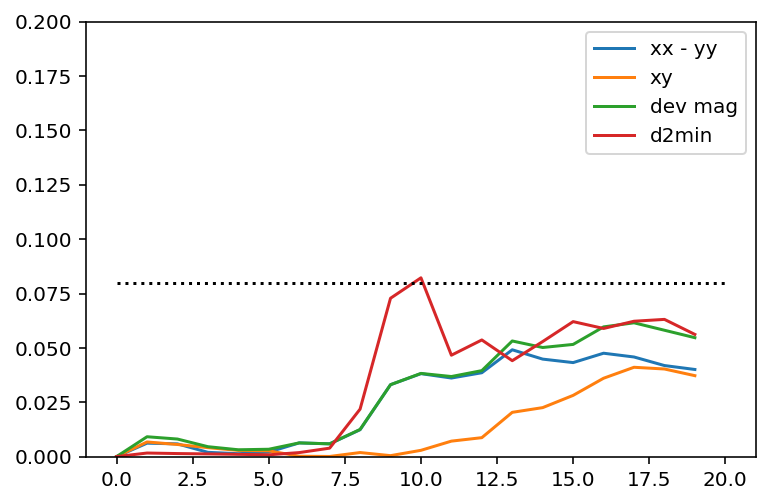

In [57]:
jdx = 2
plt.plot(tmpa[:,jdx], label="xx - yy")
plt.plot(tmpb[:,jdx], label="xy")
plt.plot(tmpc[:,jdx], label="dev mag")
plt.plot(tmp2[:,jdx], label="d2min")
plt.legend()
plt.ylim(0, 0.2)
plt.hlines(0.08, 0, 20, "k", ls=":")

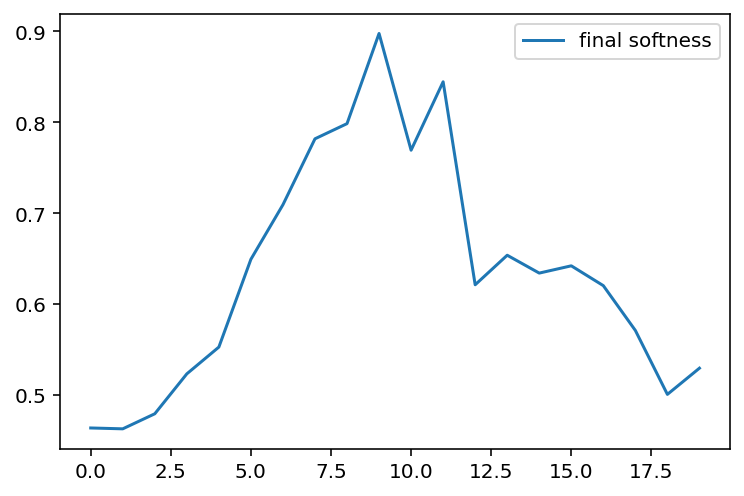

In [58]:
plt.plot(final_soft[:,jdx], label="final softness")
plt.legend()

In [52]:
final_soft[:, idx]

array([[-0.35763368,  0.66169363,  0.46405545, ..., -0.7948712 ,
         0.08918129,  0.0296688 ],
       [-0.35817224,  0.61684483,  0.46310776, ..., -0.76315624,
         0.11484157,  0.01039853],
       [-0.367599  ,  0.62268573,  0.47965646, ..., -0.8164752 ,
         0.10436704,  0.02338188],
       ...,
       [-0.5176218 ,  0.79090405,  0.57125777, ..., -1.2711414 ,
         0.17454311, -0.02640848],
       [-0.5242158 ,  0.84393716,  0.5009795 , ..., -1.2327422 ,
         0.23594841, -0.07558046],
       [-0.62180203,  0.9855471 ,  0.529791  , ..., -1.2530552 ,
         0.17560405,  0.08252726]], dtype=float32)